In [1]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import fontManager

#Colab ÈÄ≤Ë°åmatplotlibÁπ™ÂúñÊôÇÈ°ØÁ§∫ÁπÅÈ´î‰∏≠Êñá
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud


--2023-09-13 19:54:23--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 173.194.218.113, 173.194.218.102, 173.194.218.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.218.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c8q1u2bjl5uecffmrq9e4cede2jdt3bs/1694634825000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=0701715d-ae50-4d73-b17b-2309c95d1215 [following]
--2023-09-13 19:54:27--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c8q1u2bjl5uecffmrq9e4cede2jdt3bs/1694634825000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=0701715d-ae50-4d73-b17b-2309c95d1215
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 108.177.13.132, 2607:f8b0:400c:c09::84
Connecting to do

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
API_KEY = 'Input your API key here'

In [3]:
channel_ids = ['UCvTe3Z7TZsjGzUERx4Ce6zA',
        'UCEtw3BDrzbo6x2aFCEiEqfw',
        'UCFUtqTcgJgRnmZ3tMU6P74Q'
        # more channels here
        ]
#To get the channel id, you can use this link: https://commentpicker.com/youtube-channel-id.php

In [4]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
  api_service_name, api_version, developerKey = API_KEY)

In [5]:
def get_channel_stats(youtube, channel_ids):

  all_data = []

  request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=",".join(channel_ids)
  )
  response = request.execute()

  # loop through items
  for item in response['items']:
      data = {'channelName': item['snippet']['title'],
            'subscribers': item['statistics']['subscriberCount'],
            'views': item['statistics']['viewCount'],
            'totalVideos': item['statistics']['videoCount'],
            'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
      }

      all_data.append(data)

  return pd.DataFrame(all_data)

In [6]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [7]:
channel_stats

channelName subscribers       views totalVideos                playlistId
0  ÊîùÂæíÊó•Ë®òFun TV      794000   413460078        1398  UUvTe3Z7TZsjGzUERx4Ce6zA
1     Namewee     3530000  1669281636        1048  UUFUtqTcgJgRnmZ3tMU6P74Q
2       Èô≥ËÄÅÂ∏´‰æÜ‰∫Ü      414000    41163056         112  UUEtw3BDrzbo6x2aFCEiEqfw

In [8]:
playlistId="UUvTe3Z7TZsjGzUERx4Ce6zA"

def get_video_ids(youtube, playlist_id):

    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
    #Âõ†ÁÇ∫maxResultsÂè™ËÉΩÊúÄÂ§öÊèêÂèñ50ÂÄãResultÔºåÂõ†Ê≠§ÈúÄË¶ÅÁî®while loop‰∏ÄÁõ¥ÊêúÂ∞ãÂà∞ÊúÄÂæå‰∏ÄÈ†ÅÔºåÁç≤ÂèñÂÖ®ÈÉ®video id
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')

    return video_ids

In [9]:
video_ids = get_video_ids(youtube, playlistId)
len(video_ids)

1319

In [10]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    #Âõ†ÁÇ∫APIÈôêÂà∂Ôºå‰∏ÄÊ¨°ÊúÄÂ§öÂè™ÂèØ‰ª•ÊèêÂèñ50ÂÄãÁµêÊûúÔºåÊâÄ‰ª•for loopÈúÄË¶ÅÊØè50Ë∑≥
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

In [11]:
video_df = get_video_details(youtube, video_ids)
video_df

video_id channelTitle  \
0     VbU1n6ZS4pU   ÊîùÂæíÊó•Ë®òFun TV   
1     HNkL18b_al0   ÊîùÂæíÊó•Ë®òFun TV   
2     T8U1Dd2VupU   ÊîùÂæíÊó•Ë®òFun TV   
3     lfuWJqhCJtU   ÊîùÂæíÊó•Ë®òFun TV   
4     u1rZSAQ1auM   ÊîùÂæíÊó•Ë®òFun TV   
...           ...          ...   
1314  CdjbKWoLQT0   ÊîùÂæíÊó•Ë®òFun TV   
1315  b3esFwRBLtY   ÊîùÂæíÊó•Ë®òFun TV   
1316  Fdh52HvQBOo   ÊîùÂæíÊó•Ë®òFun TV   
1317  Wi7NAlypr0c   ÊîùÂæíÊó•Ë®òFun TV   
1318  KLPLP824oQo   ÊîùÂæíÊó•Ë®òFun TV   

                                                  title  \
0           ÊâìËáâËèØÁÇ∫ÁôºÂ∏ÉÊúÉÔºÅÂ∞èÁ≤âÁ¥ÖÈ≠îÂæÅÂóÜ‚ãØÂ§ßÁßÄ‰∏≠ÂúãÈÅôÈÅôÈ†òÂÖàÊäÄË°ì‚ãØ‰∏çÊñôMate 60 ProÁøªËªä‰∫Ü‚ãØ   
1           ‰∏≠Âúã‰∫îÈÉ®ÊÅ•Â∫¶ÁâπËºØÔºÅÂ∞èÁ≤âÁ¥ÖÂ∞∑Â∞¨ÁßÄ‚ãØÊâìÂÄíÁâπÊñØÊãâ‚ãØÊúàÂÖ•‰∏âÂçÉË∂ÖË∂äÂè∞ÁÅ£‚ãØÂè∞ÁÅ£ÈòøÂÖ¨ÂÖ•Á±çÊèõ‰∏≠ÂúãË≠∑ÁÖß‚ãØ   
2                             Âè∞ÁÅ£‰∫∫Â∞èÁúºÁùõÔºåÂ∞±ÊòØÂÇ∑ÂÆ≥‰∏≠Âúã‰∫∫ÊÑüÊÉÖÔºÅ #shorts   
3     ‰∏≠ÂúãËÄÅÁàπÂ§ßÈ¨ßÈüìÂúãÔºÅ‰∏üÂåÖÂ∞èÂ≠©‚ãØÁ®±Â∏åÊúõÂ≠©Â≠êÈÅ†Èõ¢‰∏≠ÂúãÔºõÂ∞èÁ≤âÁ¥ÖÈÄÉÁ•®ÊãçÁâáÁÇ´ËÄÄ‚ãØ‰∏≠ÂúãÁ∂≤Á¥ÖÁ©øÂîêË£ù‚ãØË¢´Ë™§Ë™çÁÇ∫...   
4     ÊÑõÂúãÁïôÂ≠∏ÁîüÂ§ßÈ¨ßÊó•Êú¨ÔºÅÊíøÂà∞Èå¢ÂåÖ‚ãØË¶ÅÊ±ÇÂ≠òÊ¨æ20%ÁÇ∫ÁçéË≥ûÔºõ‰∏≠ÂúãÁ∂≤Á¥ÖËàâÊóó‰ΩîÈ†òÊ≤ñÁπ©ÂóÜÔºö‰∏çÂÉÖÂè∞ÁÅ£ÊòØ‰∏≠ÂúãÁöÑ...   
...                                                 ...   
1314                „ÄêËä±ËìÆÊóÖÈÅäÊîªÁï•„ÄëËä±ËìÆÊôØÈªûÔΩúÊñ∞ÂüéÊùë5Â§ßÁßòÂ¢ÉÔΩúÁ´ãÈúßÊ∫™Âá∫Êµ∑Âè£ÊØîÂÅ∂ÂÉèÂäáÂ†¥ÊôØÈÇÑÁæé   
1315  „ÄêËä±ËìÆÊóÖÈÅäÊîªÁï•„ÄëËä±ËìÆÊôØÈªûÔΩúÂ§™È≠ØÈñ£ÁôΩÊ•äÊ≠•ÈÅìÊ∞¥ÊøÇÊ¥û [Taiwan Travel ] Huali...   
1316                             Ëä±ËìÆÊ¥ªÂãïÔΩú2018Â§™È≠ØÈñ£Èü≥Ê®ÇÁ•≠ÔΩúÂ§öÂÖÉÊ∞ëÊóèÂÖ±Ëûç   
1317                      „ÄêËä±ËìÆÊóÖÈÅäÊîªÁï•„ÄëËä±ËìÆÊôØÈªûÔΩúÂ±¨ÊñºËä±ËìÆÊñáÈùíÁöÑÂçöÊÑõÁâπÂçÄÔΩúÂç≥Â∞áÁÜÑÁáà   
1318            „ÄêËä±ËìÆÊóÖÈÅäÊîªÁï•„ÄëËä±ËìÆÊôØÈªûÔΩúÂÖ®Âè∞ÊúÄÁæéÊòüÂ∑¥ÂÖãÔΩú Âéü‰ΩèÊ∞ëÂúñÈ®∞Ë≤®Ê´ÉÂ±ãÊàêÁÇ∫Ëä±ËìÆ‰∫∫Ê∞£Êñ∞ÊôØÈªû   

                                            description  \
0     üì∫Ô∏èÈ†ªÈÅìÊúÉÂì°Ôºöhttps://www.youtube.com/channel/UCvTe3Z...   
1     üì∫Ô∏èÈ†ªÈÅìÊúÉÂì°Ôºöhttps://www.youtube.com/channel/UCvTe3Z...   
2     üì∫Ô∏èÈ†ªÈÅìÊúÉÂì°Ôºöhttps://www.youtube.com/channel/UCvTe3Z...   
3     ‰∏≠ÂúãÁà∏Áà∏Ëä±ÂÖâÁ©çËìÑÔºåÊîúÂ∏∂9Ê≠≤Â∞èÂ≠©ÂÖ±ÈÅäÈüìÂúãÔºå‰æøÂ∞áÂÖ∂Â≠©Â≠ê‰∏üÂåÖÂú®ÈüìÂúãÊüêÂ∫ßÂÖ¨Âúí‚ãØ‰∏¶ÈôÑ‰∏ä‰∏ÄÂ∞ÅËã±Êñá‰ø°Ë°®Á§∫Ôºö...   
4     ‰∏ÄÂêçÂú®Êó•Êú¨ÊÑõÂúãÁïôÂ≠∏ÁîüÔºåËøëÊó•Âú®Êù±‰∫¨ËªäÁ´ôÂÖßÊíøÂà∞Èå¢ÂåÖÔºåÈö®ÂæåÈÄÅ‰∫§Á´ôÂãô‰∫∫Âì°ÔºåÁï∂‰∏ãÁøªÁúãÂÖßÂÆπÁâ©ÔºåÁôºÁèæË£°Èù¢Êúâ...   
...                                                 ...   
1314  ÊîùÂæíÊó•Ë®ò-89ÂéªÊóÖË°å\n\nÊõºÊ≥¢È≠öÁöÑÊïÖÈÑâÔºåÊñ∞ÂüéÊùëÁöÑÁç®ÂÆ∂Êé®Ëñ¶\nÂæÄÂæÄÂ§ßÂÆ∂ÊâÄÁÜüÊÇâÁöÑÊñ∞ÂüéÂè™ÊúÉÊÉ≥Âà∞‰∏É...   
1315  Âú®Â§™È≠ØÈñ£Â§©Á••Â±±ÂçÄ‰∏çÈÅ†ËôïÁöÑÁôΩÊ•äÊ≠•ÈÅìÊ∞¥ÊøÇÊ¥û\nÂ∞ÅÈñâ1Âπ¥Â§öÂæåÔºåÂú®10Êúà28Êó•ÈáçÊñ∞ÈñãÊîæ\nÂ§èÂ§©‰æÜÂà∞Â±±...   
1316  ÊîùÂæíÊó•Ë®ò-89ÂéªÊóÖË°åÁöÑ‰∏ªÊåÅ‰∫∫\nÊú¨Ë∫´Èô§‰∫ÜÊòØÈÅìÂú∞ÁöÑËä±ËìÆ‰∫∫‰πãÂ§ñ\nÊõ¥ÊòØÂ§™È≠ØÈñ£ÊóèÁöÑ‰∏ÄÂì°\nÈÄôÊ¨°‰ªãÁ¥π...   
1317  ÊîùÂæíÊó•Ë®ò-89ÂéªÊóÖË°å\n\nË∂ïÂú®10/31ÁµêÊùüÁáüÊ•≠ÂâçÔºå‰æÜÊãçÊîùÂçöÊÑõÁâπÂçÄ\nÁ¥ÄÈåÑ‰ªñÊúÄÂæåÁöÑÁæéË≤åÔºåÁµ¶...   
1318  ÊîùÂæíÊó•Ë®ò-89ÂéªÊóÖË°å\n\nËä±ËìÆÂêâÂÆâÈÑâ Ê¥ÑÁÄæË≤®Ê´ÉÂ±ãÊòüÂ∑¥ÂÖãÈñÄÂ∏Ç\nÊ¥ÑÁÄæÈñÄÂ∏ÇÂùêËêΩÊñºËøéÊé•Â§™Âπ≥Ê¥ãÈù¢Âçá...   

                                                   tags           publishedAt  \
0     [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ, ËèØÁÇ∫mate 60 pro,...  2023-09-13T13:16:31Z   
1     [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ, ÊîùÂæíÊó•Ë®ò Â∞èÁ≤âÁ¥ÖÈÄöË©±, ÊîùÂæí...  2023-09-12T13:16:53Z   
2                       [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ]  2023-09-12T11:41:45Z   
3     [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ, ÊîùÂæíÊó•Ë®ò Â∞èÁ≤âÁ¥ÖÈÄöË©±, ÊîùÂæí...  2023-09-11T13:16:24Z   
4     [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ, ÊîùÂæíÊó•Ë®ò Â∞èÁ≤âÁ¥ÖÈÄöË©±, ÊîùÂæí...  2023-09-10T12:46:25Z   
...                                                 ...                   ...   
1314  [Ëä±ËìÆ, ÊôØÈªû, Êñ∞Âüé, ‰∏ÉÊòüÊΩ≠, Ê™∏Ê™¨Ê±Å, Â§©‰∏ªÂ†Ç, 

In [12]:
def get_comments_in_videos(youtube, video_ids):
  """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:

    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs

    Returns:
    Dataframe with video IDs and associated top level comment in text.

  """
  all_comments = []

  for video_id in video_ids:
      try:
          request = youtube.commentThreads().list(
              part="snippet,replies",
              videoId=video_id
          )
          response = request.execute()

          comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
          comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

          all_comments.append(comments_in_video_info)

      except:
          # When error occurs - most likely because comments are disabled on a video
          print('Could not get comments for video ' + video_id)

  return pd.DataFrame(all_comments)

In [13]:
comment_df = get_comments_in_videos(youtube, video_ids)
comment_df

video_id                                           comments
0     VbU1n6ZS4pU  [Âçé‰∏∫È∫íÈ∫ü9000SÊòØ‰∏≠ËäØÂõΩÈôÖÂõΩ‰∫ßÂÖâÂàªÊú∫‰∫ßÁöÑÔºå‰ΩøÁî®ÊúÄÂÖàËøõÁöÑÂ§öÈáçÊõùÂÖâÊäÄÊúØÔºåÂèçÂ§çÂ•óÂàªÂà∂‰ΩúÁöÑ7Á∫≥Á±≥...
1     HNkL18b_al0  [‰∏≠ÂõΩÂõΩÁ±çÊòØÂÖ®‰∏ñÁïåÊúÄÈöæÂÖ•ÁöÑÔºå‰∏ÄÂ†Ü‰∫∫ÊéíÈòüÈÉΩÂÖ•‰∏ç‰∫ÜÔºåÁõÆÂâçÂè™Êúâ‰∫î‰∏™Â§ñÂõΩ‰∫∫ÊãøÂà∞ÔºåÊùéËøûÊù∞ÈÄÄÂá∫‰∏≠ÂõΩÁ±çÂêéÊÇî...
2     T8U1Dd2VupU  [Ê±óÂ•∏ÁúºÁùõ, Âá∫‰æÜÂïäÔºå‰∏ãÈù¢ÊÄéÈ∫ºÊ≤íË¶ãÂà∞‰ªª‰Ωï‰∏ÄÂÄãÊ≠ªÁ≤âÁ¥Ö, ÁøíË±¨È†≠ÂæÆÁµ≤Á¥∞Áúº‰πüË™çÁúüËæ±ÂúãÔºåÈºªÂ§ßÁúºÁ¥∞‰∏ü‰∏≠...
3     lfuWJqhCJtU  [ÂÖ´Ëø•ÔºåÊàëÊúÄËøëÊ≤°ÊúâÈó≤Èí±ÂèØ‰ª•ÂéªÂÜÖËíôËØÅÊòéÔºå‰ΩÜÊàëÂèØ‰ª•‰øùËØÅZGÁöÑÈìÄÁÖ§ÂºÄÈááÊòØÂú®ÂêàÁêÜÂíåËßÑÁöÑËåÉÂõ¥ÂÜÖÔºåÊàë‰∏ã‰∏™...
4     u1rZSAQ1auM  [ÁÖûÊØîÔΩûÊàëÊòéÂ§©Â∞±ÂâçÂéªÂÖßËíôÊ≠£Âêç\nÂêÉ‰∏Ä‰∏™ÈàæÁüø‰æÜÁúãÁúãÔºÅzg Ê≤íÊúâÊ†∏Ê±ô, ÁúãËßÅ‰Ω†Á¨ëÔºåÊàëÁúüÁöÑÂ•ΩÊÉ≥Âì≠Ôºå...
...           ...                                                ...
1314  CdjbKWoLQT0  [ËÆöüëç, ÂèØ‰ª•ÁúãÂæóÂá∫‰æÜ‰Ω†ÂæàÊÑõ‰Ω†Èï∑Â§ßÁöÑÂú∞ÊñπÔºå‰Ω†ÁöÑÂÆ∂Ôºå‰Ω†ÁöÑÂúãÔºå‰∏çÁÑ∂‰∏çÊúÉÈÄôÊ®£ÁöÑ‰∫ÜËß£ÂÆÉÔºå‰πüÂ∏∂ËëóÂ§ßÂÆ∂‰∏Ä...
1315  b3esFwRBLtY  [Êùû‰∫∫ÊÜÇÂ§©ÁöÑÁâåÂ≠êüòÇüòÇüòÇ, Â§öÊãçÂÄãÁæéÂ•ΩÂè∞ÁÅ£ÁöÑÈ¢®ÊôØ, ÈÄôË£°ÊòØÂ∞öÊú™ÈÅ≠ÂèóÁ≤âÁ¥ÖÊîªÊìäÁöÑÊ∑®Âúü, Áà¨Â±±Á©øÁöÆË°£...
1316  Fdh52HvQBOo  [ÁãóÊùÇÁßç, ÂÖ∂ÂØ¶‰Ω†Â™ΩÊ†πÊú¨‰∏çÈóúÂøÉ‰Ω†ÂïäüòÇ, ÈÖ∑ÔºåËøô‰∫õÊñáÂåñÁúüÁöÑÂ•ΩÊ£íÔºåÊàëÂ¶àÂ¶àÊòØÈ©¨Êù•Ë•ø‰∫öÁöÑÂç°ËææÂ±±ÊóèÁöÑÔºå...
1317  Wi7NAlypr0c  [ÂìáÂóöüòÉ, ËÄÉÂè§Âï¶, ÊàëÂÄëË¶ÅÁç®Á´ãÂª∫Âúã Âè∞ÁÅ£ÂÖ±ÂíåÂúã Ëê¨Ê≠≤, ÂæûÊóÖÈÅäÁæéÈ£üÁØÄÁõÆËÆäËæ±ËèØÁØÄÁõÆ, Ëæ±ËèØ,...
1318  KLPLP824oQo  [‰Ω†ÂÄãÁøíËøëÂπ≥, l amËÄÉÂè§Â≠∏ÂÆ∂, 25Â≤ÅÁöÑ89, Âìá 4Âπ¥ÂâçÁöÑÂÖ´ÁÇØ‚ù§, 2023‰æÜËÄÉÂè§, ...

[1319 rows x 2 columns]

## Data pre-processing

In [14]:
video_df.isnull().any() #check for NULL values

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [15]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [16]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [17]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [18]:
pip install isodate

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41.7/41.7 kB 1.1 MB/s eta 0:00:00


In [19]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [20]:
video_df[['durationSecs', 'duration']]

durationSecs  duration
0            663.0   PT11M3S
1            771.0  PT12M51S
2             44.0     PT44S
3            641.0  PT10M41S
4            652.0  PT10M52S
...            ...       ...
1314         293.0   PT4M53S
1315         291.0   PT4M51S
1316         301.0    PT5M1S
1317          80.0   PT1M20S
1318          80.0   PT1M20S

[1319 rows x 2 columns]

In [21]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [22]:
video_df

video_id channelTitle  \
0     VbU1n6ZS4pU   ÊîùÂæíÊó•Ë®òFun TV   
1     HNkL18b_al0   ÊîùÂæíÊó•Ë®òFun TV   
2     T8U1Dd2VupU   ÊîùÂæíÊó•Ë®òFun TV   
3     lfuWJqhCJtU   ÊîùÂæíÊó•Ë®òFun TV   
4     u1rZSAQ1auM   ÊîùÂæíÊó•Ë®òFun TV   
...           ...          ...   
1314  CdjbKWoLQT0   ÊîùÂæíÊó•Ë®òFun TV   
1315  b3esFwRBLtY   ÊîùÂæíÊó•Ë®òFun TV   
1316  Fdh52HvQBOo   ÊîùÂæíÊó•Ë®òFun TV   
1317  Wi7NAlypr0c   ÊîùÂæíÊó•Ë®òFun TV   
1318  KLPLP824oQo   ÊîùÂæíÊó•Ë®òFun TV   

                                                  title  \
0           ÊâìËáâËèØÁÇ∫ÁôºÂ∏ÉÊúÉÔºÅÂ∞èÁ≤âÁ¥ÖÈ≠îÂæÅÂóÜ‚ãØÂ§ßÁßÄ‰∏≠ÂúãÈÅôÈÅôÈ†òÂÖàÊäÄË°ì‚ãØ‰∏çÊñôMate 60 ProÁøªËªä‰∫Ü‚ãØ   
1           ‰∏≠Âúã‰∫îÈÉ®ÊÅ•Â∫¶ÁâπËºØÔºÅÂ∞èÁ≤âÁ¥ÖÂ∞∑Â∞¨ÁßÄ‚ãØÊâìÂÄíÁâπÊñØÊãâ‚ãØÊúàÂÖ•‰∏âÂçÉË∂ÖË∂äÂè∞ÁÅ£‚ãØÂè∞ÁÅ£ÈòøÂÖ¨ÂÖ•Á±çÊèõ‰∏≠ÂúãË≠∑ÁÖß‚ãØ   
2                             Âè∞ÁÅ£‰∫∫Â∞èÁúºÁùõÔºåÂ∞±ÊòØÂÇ∑ÂÆ≥‰∏≠Âúã‰∫∫ÊÑüÊÉÖÔºÅ #shorts   
3     ‰∏≠ÂúãËÄÅÁàπÂ§ßÈ¨ßÈüìÂúãÔºÅ‰∏üÂåÖÂ∞èÂ≠©‚ãØÁ®±Â∏åÊúõÂ≠©Â≠êÈÅ†Èõ¢‰∏≠ÂúãÔºõÂ∞èÁ≤âÁ¥ÖÈÄÉÁ•®ÊãçÁâáÁÇ´ËÄÄ‚ãØ‰∏≠ÂúãÁ∂≤Á¥ÖÁ©øÂîêË£ù‚ãØË¢´Ë™§Ë™çÁÇ∫...   
4     ÊÑõÂúãÁïôÂ≠∏ÁîüÂ§ßÈ¨ßÊó•Êú¨ÔºÅÊíøÂà∞Èå¢ÂåÖ‚ãØË¶ÅÊ±ÇÂ≠òÊ¨æ20%ÁÇ∫ÁçéË≥ûÔºõ‰∏≠ÂúãÁ∂≤Á¥ÖËàâÊóó‰ΩîÈ†òÊ≤ñÁπ©ÂóÜÔºö‰∏çÂÉÖÂè∞ÁÅ£ÊòØ‰∏≠ÂúãÁöÑ...   
...                                                 ...   
1314                „ÄêËä±ËìÆÊóÖÈÅäÊîªÁï•„ÄëËä±ËìÆÊôØÈªûÔΩúÊñ∞ÂüéÊùë5Â§ßÁßòÂ¢ÉÔΩúÁ´ãÈúßÊ∫™Âá∫Êµ∑Âè£ÊØîÂÅ∂ÂÉèÂäáÂ†¥ÊôØÈÇÑÁæé   
1315  „ÄêËä±ËìÆÊóÖÈÅäÊîªÁï•„ÄëËä±ËìÆÊôØÈªûÔΩúÂ§™È≠ØÈñ£ÁôΩÊ•äÊ≠•ÈÅìÊ∞¥ÊøÇÊ¥û [Taiwan Travel ] Huali...   
1316                             Ëä±ËìÆÊ¥ªÂãïÔΩú2018Â§™È≠ØÈñ£Èü≥Ê®ÇÁ•≠ÔΩúÂ§öÂÖÉÊ∞ëÊóèÂÖ±Ëûç   
1317                      „ÄêËä±ËìÆÊóÖÈÅäÊîªÁï•„ÄëËä±ËìÆÊôØÈªûÔΩúÂ±¨ÊñºËä±ËìÆÊñáÈùíÁöÑÂçöÊÑõÁâπÂçÄÔΩúÂç≥Â∞áÁÜÑÁáà   
1318            „ÄêËä±ËìÆÊóÖÈÅäÊîªÁï•„ÄëËä±ËìÆÊôØÈªûÔΩúÂÖ®Âè∞ÊúÄÁæéÊòüÂ∑¥ÂÖãÔΩú Âéü‰ΩèÊ∞ëÂúñÈ®∞Ë≤®Ê´ÉÂ±ãÊàêÁÇ∫Ëä±ËìÆ‰∫∫Ê∞£Êñ∞ÊôØÈªû   

                                            description  \
0     üì∫Ô∏èÈ†ªÈÅìÊúÉÂì°Ôºöhttps://www.youtube.com/channel/UCvTe3Z...   
1     üì∫Ô∏èÈ†ªÈÅìÊúÉÂì°Ôºöhttps://www.youtube.com/channel/UCvTe3Z...   
2     üì∫Ô∏èÈ†ªÈÅìÊúÉÂì°Ôºöhttps://www.youtube.com/channel/UCvTe3Z...   
3     ‰∏≠ÂúãÁà∏Áà∏Ëä±ÂÖâÁ©çËìÑÔºåÊîúÂ∏∂9Ê≠≤Â∞èÂ≠©ÂÖ±ÈÅäÈüìÂúãÔºå‰æøÂ∞áÂÖ∂Â≠©Â≠ê‰∏üÂåÖÂú®ÈüìÂúãÊüêÂ∫ßÂÖ¨Âúí‚ãØ‰∏¶ÈôÑ‰∏ä‰∏ÄÂ∞ÅËã±Êñá‰ø°Ë°®Á§∫Ôºö...   
4     ‰∏ÄÂêçÂú®Êó•Êú¨ÊÑõÂúãÁïôÂ≠∏ÁîüÔºåËøëÊó•Âú®Êù±‰∫¨ËªäÁ´ôÂÖßÊíøÂà∞Èå¢ÂåÖÔºåÈö®ÂæåÈÄÅ‰∫§Á´ôÂãô‰∫∫Âì°ÔºåÁï∂‰∏ãÁøªÁúãÂÖßÂÆπÁâ©ÔºåÁôºÁèæË£°Èù¢Êúâ...   
...                                                 ...   
1314  ÊîùÂæíÊó•Ë®ò-89ÂéªÊóÖË°å\n\nÊõºÊ≥¢È≠öÁöÑÊïÖÈÑâÔºåÊñ∞ÂüéÊùëÁöÑÁç®ÂÆ∂Êé®Ëñ¶\nÂæÄÂæÄÂ§ßÂÆ∂ÊâÄÁÜüÊÇâÁöÑÊñ∞ÂüéÂè™ÊúÉÊÉ≥Âà∞‰∏É...   
1315  Âú®Â§™È≠ØÈñ£Â§©Á••Â±±ÂçÄ‰∏çÈÅ†ËôïÁöÑÁôΩÊ•äÊ≠•ÈÅìÊ∞¥ÊøÇÊ¥û\nÂ∞ÅÈñâ1Âπ¥Â§öÂæåÔºåÂú®10Êúà28Êó•ÈáçÊñ∞ÈñãÊîæ\nÂ§èÂ§©‰æÜÂà∞Â±±...   
1316  ÊîùÂæíÊó•Ë®ò-89ÂéªÊóÖË°åÁöÑ‰∏ªÊåÅ‰∫∫\nÊú¨Ë∫´Èô§‰∫ÜÊòØÈÅìÂú∞ÁöÑËä±ËìÆ‰∫∫‰πãÂ§ñ\nÊõ¥ÊòØÂ§™È≠ØÈñ£ÊóèÁöÑ‰∏ÄÂì°\nÈÄôÊ¨°‰ªãÁ¥π...   
1317  ÊîùÂæíÊó•Ë®ò-89ÂéªÊóÖË°å\n\nË∂ïÂú®10/31ÁµêÊùüÁáüÊ•≠ÂâçÔºå‰æÜÊãçÊîùÂçöÊÑõÁâπÂçÄ\nÁ¥ÄÈåÑ‰ªñÊúÄÂæåÁöÑÁæéË≤åÔºåÁµ¶...   
1318  ÊîùÂæíÊó•Ë®ò-89ÂéªÊóÖË°å\n\nËä±ËìÆÂêâÂÆâÈÑâ Ê¥ÑÁÄæË≤®Ê´ÉÂ±ãÊòüÂ∑¥ÂÖãÈñÄÂ∏Ç\nÊ¥ÑÁÄæÈñÄÂ∏ÇÂùêËêΩÊñºËøéÊé•Â§™Âπ≥Ê¥ãÈù¢Âçá...   

                                                   tags  \
0     [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ, ËèØÁÇ∫mate 60 pro,...   
1     [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ, ÊîùÂæíÊó•Ë®ò Â∞èÁ≤âÁ¥ÖÈÄöË©±, ÊîùÂæí...   
2                       [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ]   
3     [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ, ÊîùÂæíÊó•Ë®ò Â∞èÁ≤âÁ¥ÖÈÄöË©±, ÊîùÂæí...   
4     [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ, ÊîùÂæíÊó•Ë®ò Â∞èÁ≤âÁ¥ÖÈÄöË©±, ÊîùÂæí...   
...                                                 ...   
1314  [Ëä±ËìÆ, ÊôØÈªû, Êñ∞Âüé, ‰∏ÉÊòüÊΩ≠, Ê™∏Ê™¨Ê±Å, Â§©‰∏ªÂ†Ç, ÊóÖÈÅä, vlog, ÁßòÂ¢É, taiw...   
1315  [Â§™È≠ØÈñ£, Ëä±ËìÆ, Ê∞¥ÊøÇÊ¥û, ÁôΩÊ•äÊ≠•ÈÅì, ÊóÖÈÅä, ÊóÖË°å, ÁßòÂ¢É, hualien, taiw...   
1316  [Â§™È≠ØÈñ£, Èü≥Ê®ÇÁ•

## Best performing videos

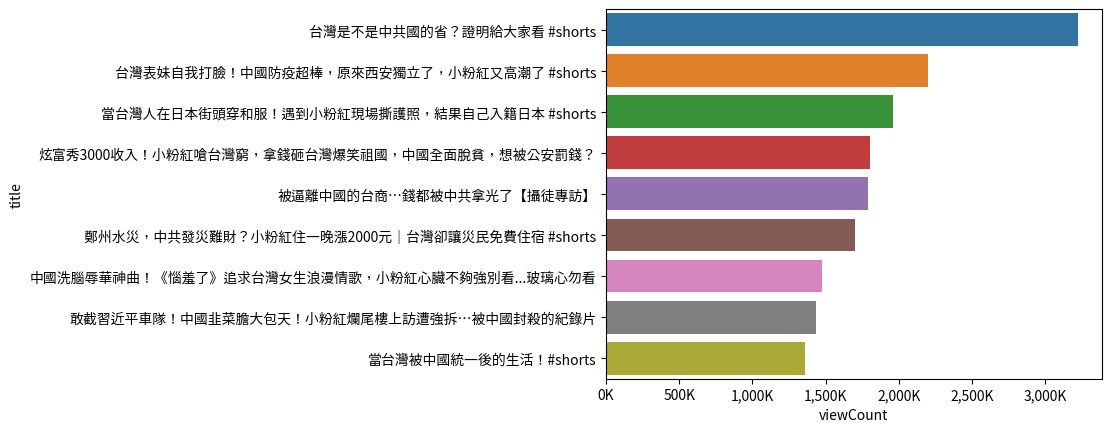

In [23]:
ax = sns.barplot(x = 'viewCount', y = 'title', data = video_df.sort_values('viewCount', ascending=False)[0:9])
# plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## Worst performing videos

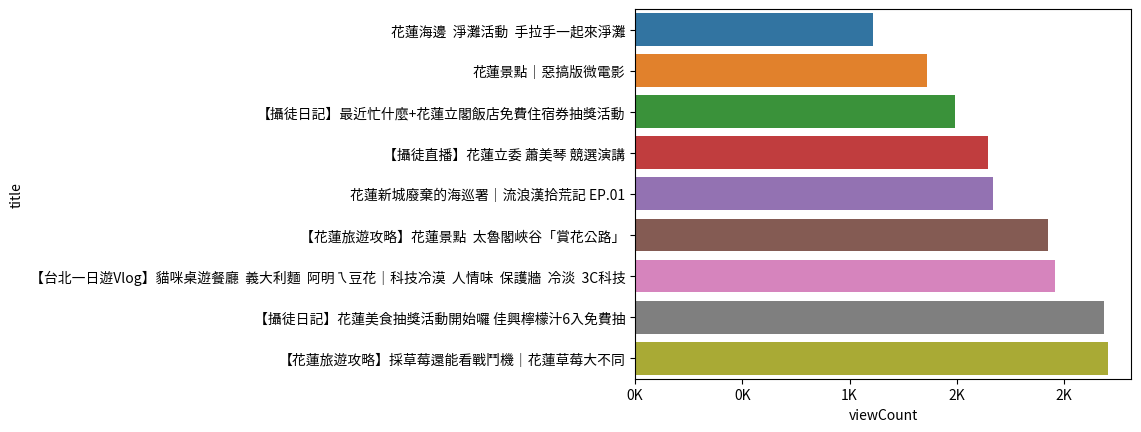

In [24]:
ax = sns.barplot(x = 'viewCount', y = 'title', data = video_df.sort_values('viewCount', ascending=True)[0:9])
# plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## View distribution per video

<Axes: xlabel='channelTitle', ylabel='viewCount'>

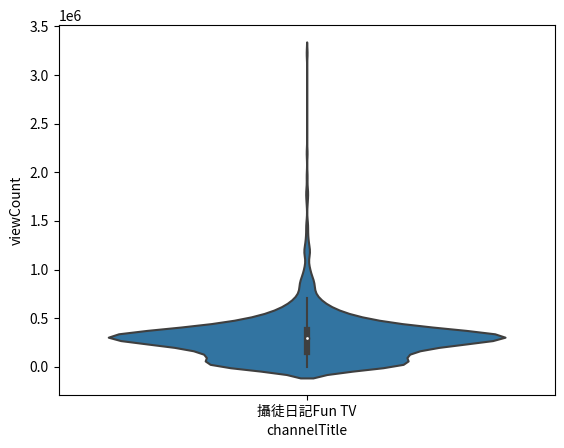

In [25]:
sns.violinplot(x=video_df['channelTitle'],y=video_df['viewCount']) #Violin plot for the channel

## Views vs. likes and comments



<Axes: xlabel='likeCount', ylabel='viewCount'>

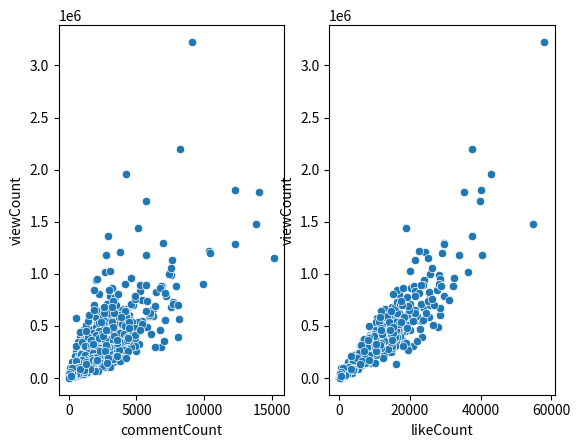

In [26]:
# get the relationship between viewCount and commentCount as well as likeCount
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

## Video duration

<Axes: xlabel='durationSecs', ylabel='Count'>

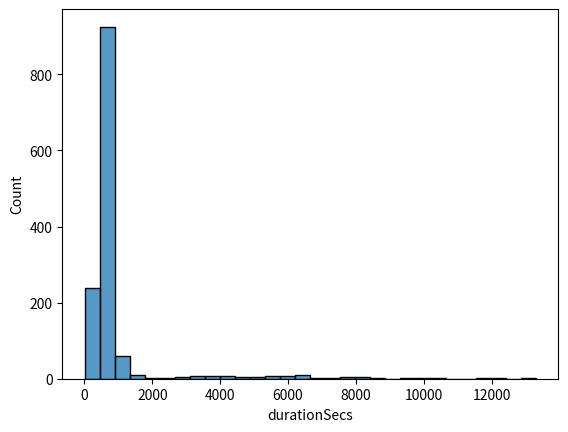

In [27]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

## Wordcloud for video titles in Chinese

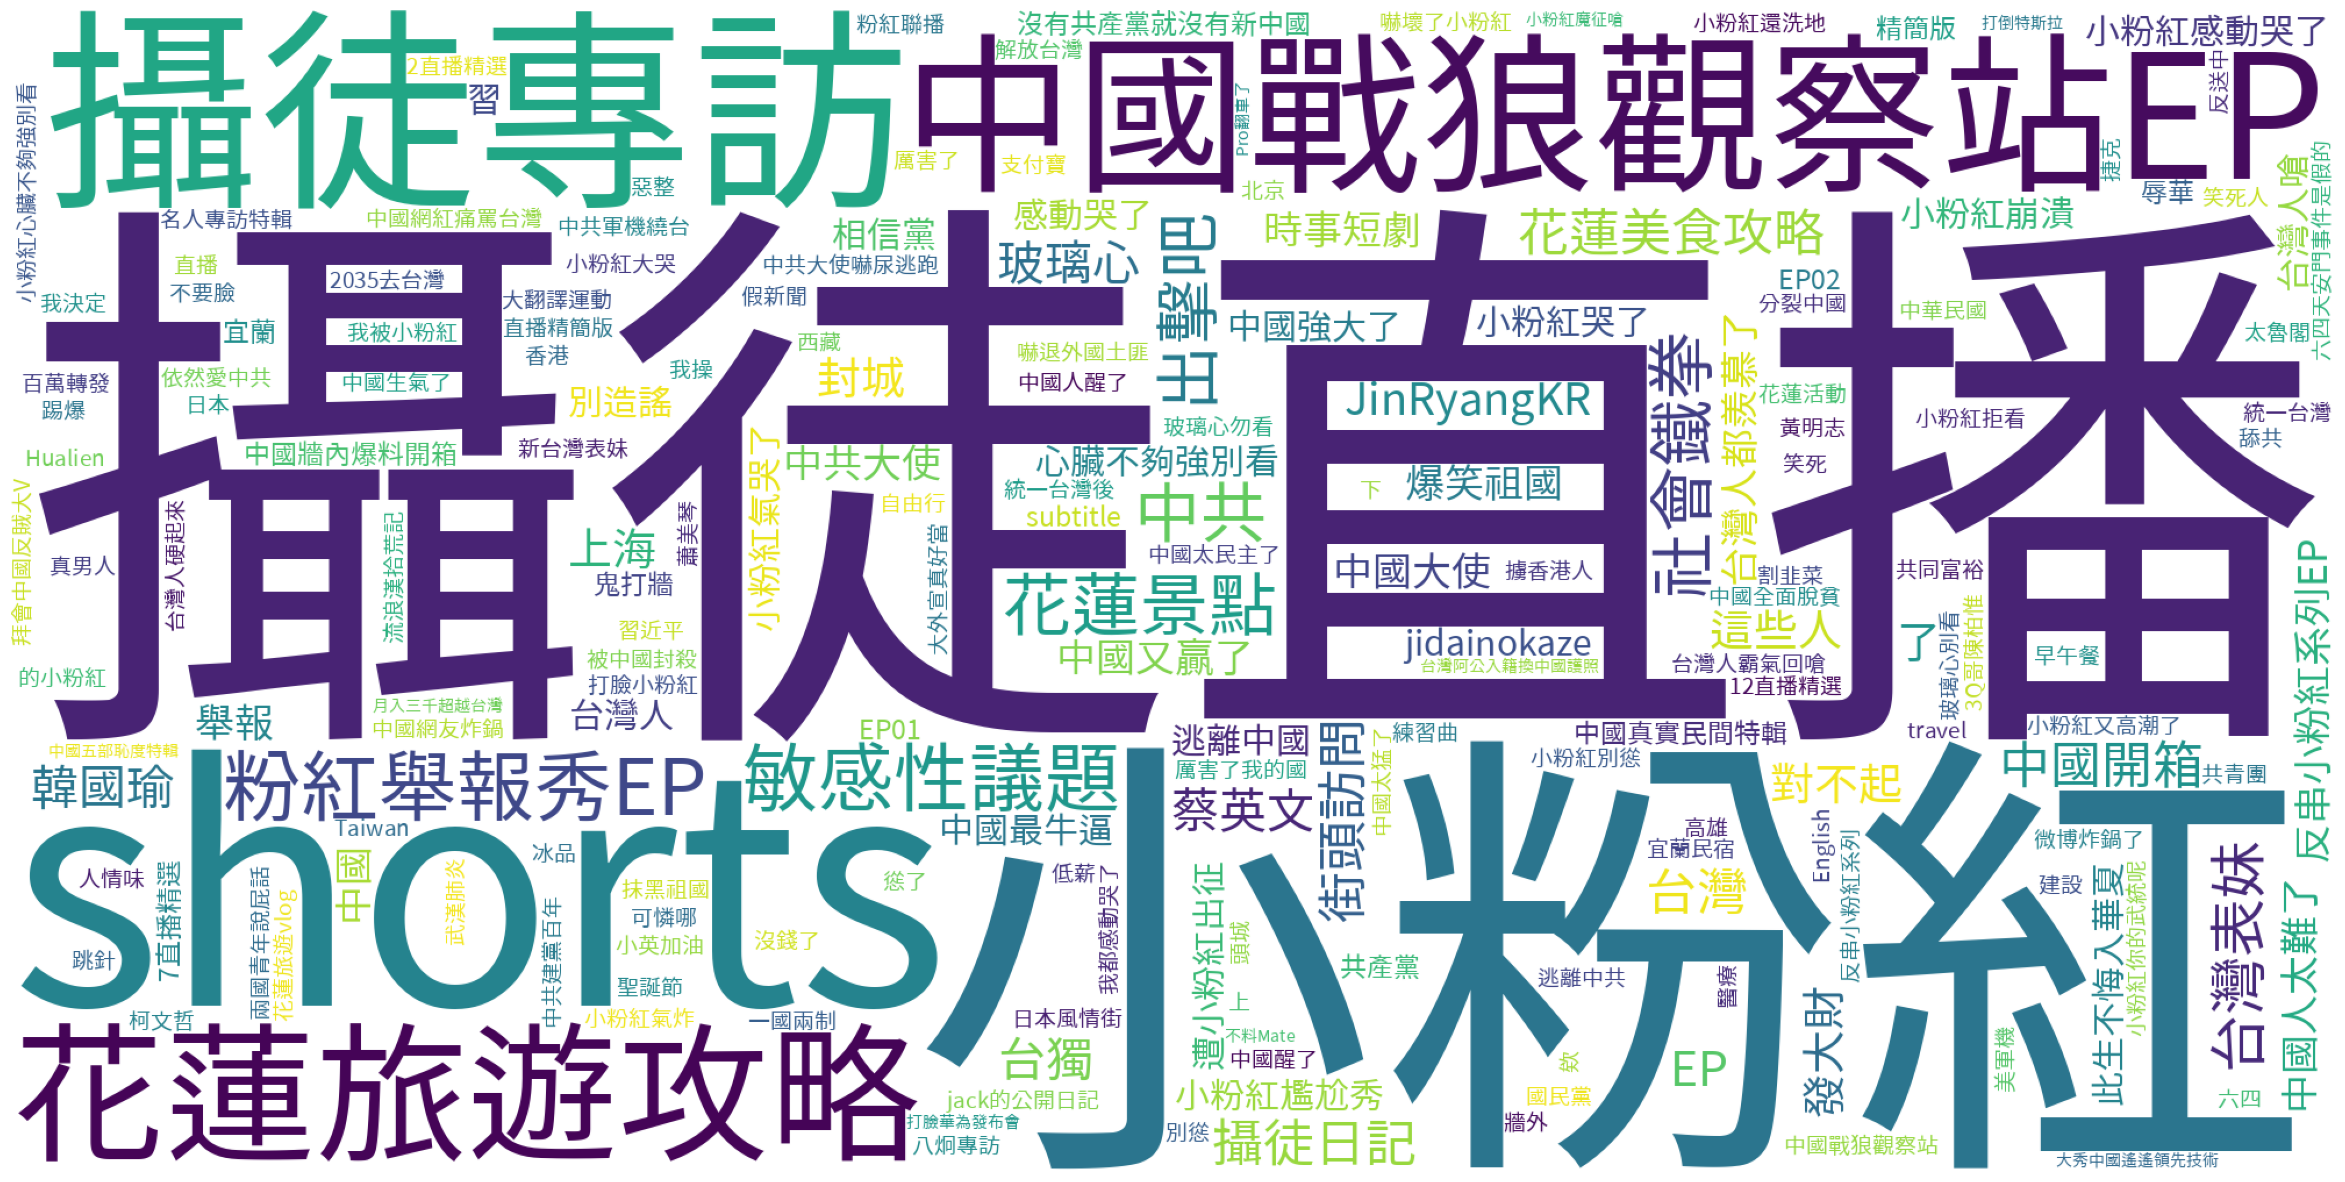

In [28]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='white',
                      colormap='viridis', collocations=False, font_path="TaipeiSansTCBeta-Regular.ttf").generate(all_words_str)
#Because that is Chinese Youtube Channel, we need to change the font_path to support Traditional Chinese
plot_cloud(wordcloud)

## Wordcloud for comments in Chinese

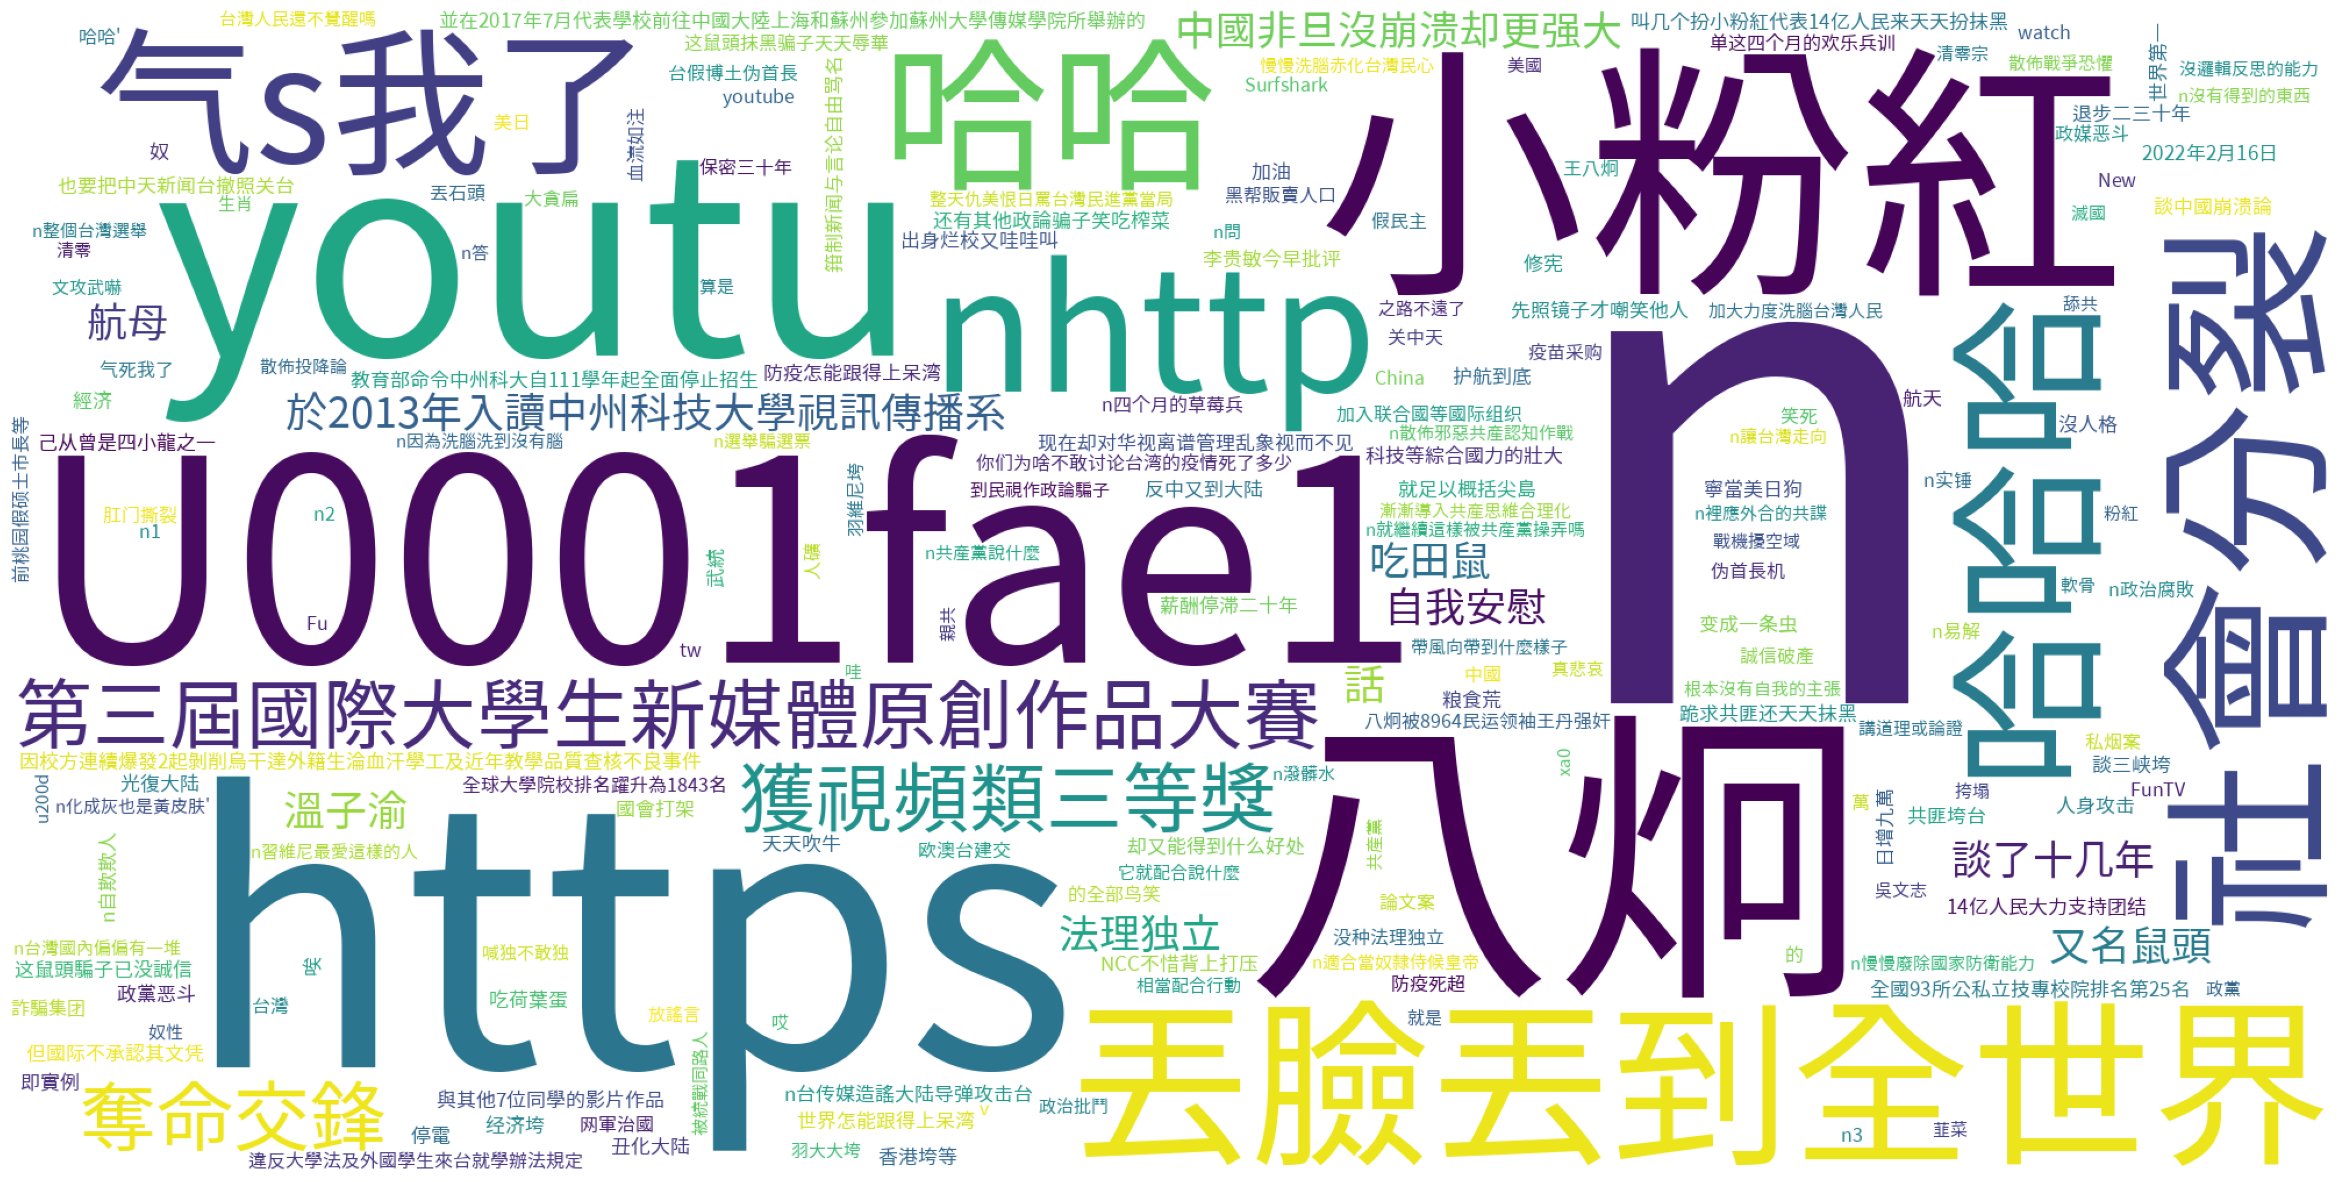

In [29]:
stop_words = set(stopwords.words('english'))
comment_df['comments_no_stopwords'] = comment_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comment_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='white',
                      colormap='viridis', collocations=False, font_path="TaipeiSansTCBeta-Regular.ttf").generate(all_words_str)
plot_cloud(wordcloud)

## Upload schedule

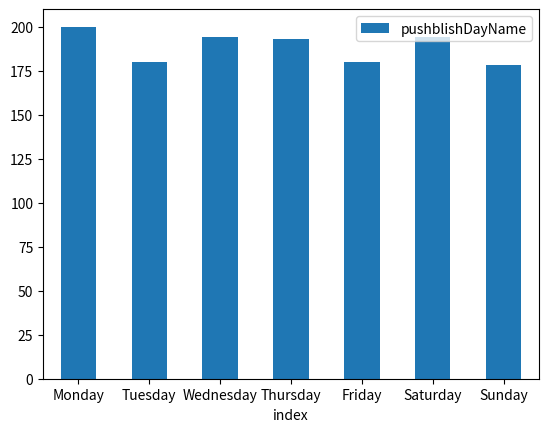

In [30]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)